# 🎯 PROJET TECHNOVA - Phase 2 : Modélisation et Feature Engineering

## CONTEXTE



---

**Objectif** : Prédire les départs d'employés chez TechNova (ESN) pour identifier les profils à risque et proposer des actions préventives.

**Données** : Dataset fusionné de 1470 employés (SIRH + Évaluations + Sondage)
- Variable cible : `a_quitte_l_entreprise` (16% de départs)
- Problématique : Classes déséquilibrées

**Stratégie de modélisation** :
- Métrique prioritaire : **Recall** (détecter un maximum de départs potentiels)
- Justification : Mieux vaut alerter à tort que rater un départ

**Ce notebook couvre** :
1. Analyse des corrélations (Pearson)
2. Feature engineering (création de variables)
3. Comparaison de modèles (Dummy, Logistic, RF, XGBoost, CatBoost)
4. Optimisation (GridSearchCV)
5. Interprétation (SHAP global + local)

## IMPORTS


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn - Préparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Sklearn - Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sklearn - Métriques
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve, PrecisionRecallDisplay
)

# Modèles avancés
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Interprétabilité
import shap

# Configuration affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Imports chargés avec succès")

✅ Imports chargés avec succès


## CHARGEMENT DES DONNÉES


In [2]:

df_start = pd.read_csv('resultats/DiBattista_Barbara_4_csv_resultat_nettoyage_122025.csv')

print(f"✅ Données chargées : {df_start.shape[0]} lignes × {df_start.shape[1]} colonnes")
print(f"\n📋 Colonnes disponibles :")
print(df_start.columns.tolist())

print(f"\n📊 Aperçu des données :")
df_start.head()




✅ Données chargées : 1470 lignes × 32 colonnes

📋 Colonnes disponibles :
['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'augmentation_num']

📊 Aperçu des données :


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,augmentation_num
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,3,Oui,11 %,Oui,0,0,1,1,2,Infra & Cloud,Occasionnel,0,5,11
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,4,Non,23 %,Non,1,3,1,8,1,Infra & Cloud,Frequent,1,7,23
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,3,Oui,15 %,Oui,0,3,1,2,2,Autre,Occasionnel,0,0,15
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,3,Oui,11 %,Non,0,3,1,3,4,Infra & Cloud,Frequent,3,0,11
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,3,Non,12 %,Non,1,3,1,2,1,Transformation Digitale,Occasionnel,2,2,12


## SÉPARATION FEATURES / CIBLE


In [3]:
# Extraire la variable cible (y)
y = df_start['a_quitte_l_entreprise'].map({'Non': 0, 'Oui': 1})

# Colonnes à exclure de X
colonnes_a_exclure = [
    'a_quitte_l_entreprise',  # Variable cible
    'id_employee',            # Identifiant (pas prédictif)
    'departement'             # Corrélé avec poste (Chi² = 2594, p < 0.001)
]

# Créer X sans la cible ni les colonnes exclues
X = df_start.drop(columns=colonnes_a_exclure)

print("✅ Séparation X / y effectuée")
print(f"\n📊 Variable cible (y) :")
print(f"   • {y.shape[0]} valeurs")
print(f"   • {y.sum()} départs ({y.mean()*100:.1f}%)")
print(f"   • {(y == 0).sum()} restés ({(y == 0).mean()*100:.1f}%)")

print(f"\n📊 Features (X) :")
print(f"   • {X.shape[0]} lignes × {X.shape[1]} colonnes")

✅ Séparation X / y effectuée

📊 Variable cible (y) :
   • 1470 valeurs
   • 237 départs (16.1%)
   • 1233 restés (83.9%)

📊 Features (X) :
   • 1470 lignes × 29 colonnes


## Matrice de corrélation de Pearson


### EXTRAIRE LES PAIRES DE CORRÉLATIONS


In [4]:
# Sélectionner uniquement les variables numériques
vars_numeriques = X.select_dtypes(include=['int64', 'float64'])

print(f"📊 Variables numériques analysées : {len(vars_numeriques.columns)}")

# Calculer la matrice de corrélation
matrice_corr = vars_numeriques.corr(method='pearson')

# ============================================
# EXTRAIRE LES PAIRES DE CORRÉLATIONS
# ============================================

paires_corr = []

for i in range(len(matrice_corr.columns)):
    for j in range(i + 1, len(matrice_corr.columns)):
        var1 = matrice_corr.columns[i]
        var2 = matrice_corr.columns[j]
        corr = matrice_corr.iloc[i, j]
        paires_corr.append({
            'Variable_1': var1,
            'Variable_2': var2,
            'Corrélation': corr,
            'Abs_Corr': abs(corr)
        })

df_corr = pd.DataFrame(paires_corr)

# ============================================
# CATÉGORISER LES CORRÉLATIONS
# ============================================

def categoriser_corr(val):
    if abs(val) >= 0.7:
        return '🔴 Forte (≥ 0.7)'
    elif abs(val) >= 0.3:
        return '🟡 Modérée (0.3-0.7)'
    else:
        return '🟢 Faible (< 0.3)'

df_corr['Catégorie'] = df_corr['Corrélation'].apply(categoriser_corr)


📊 Variables numériques analysées : 22


### MATRICE DE CORRÉLATION (GRAPHIQUE)


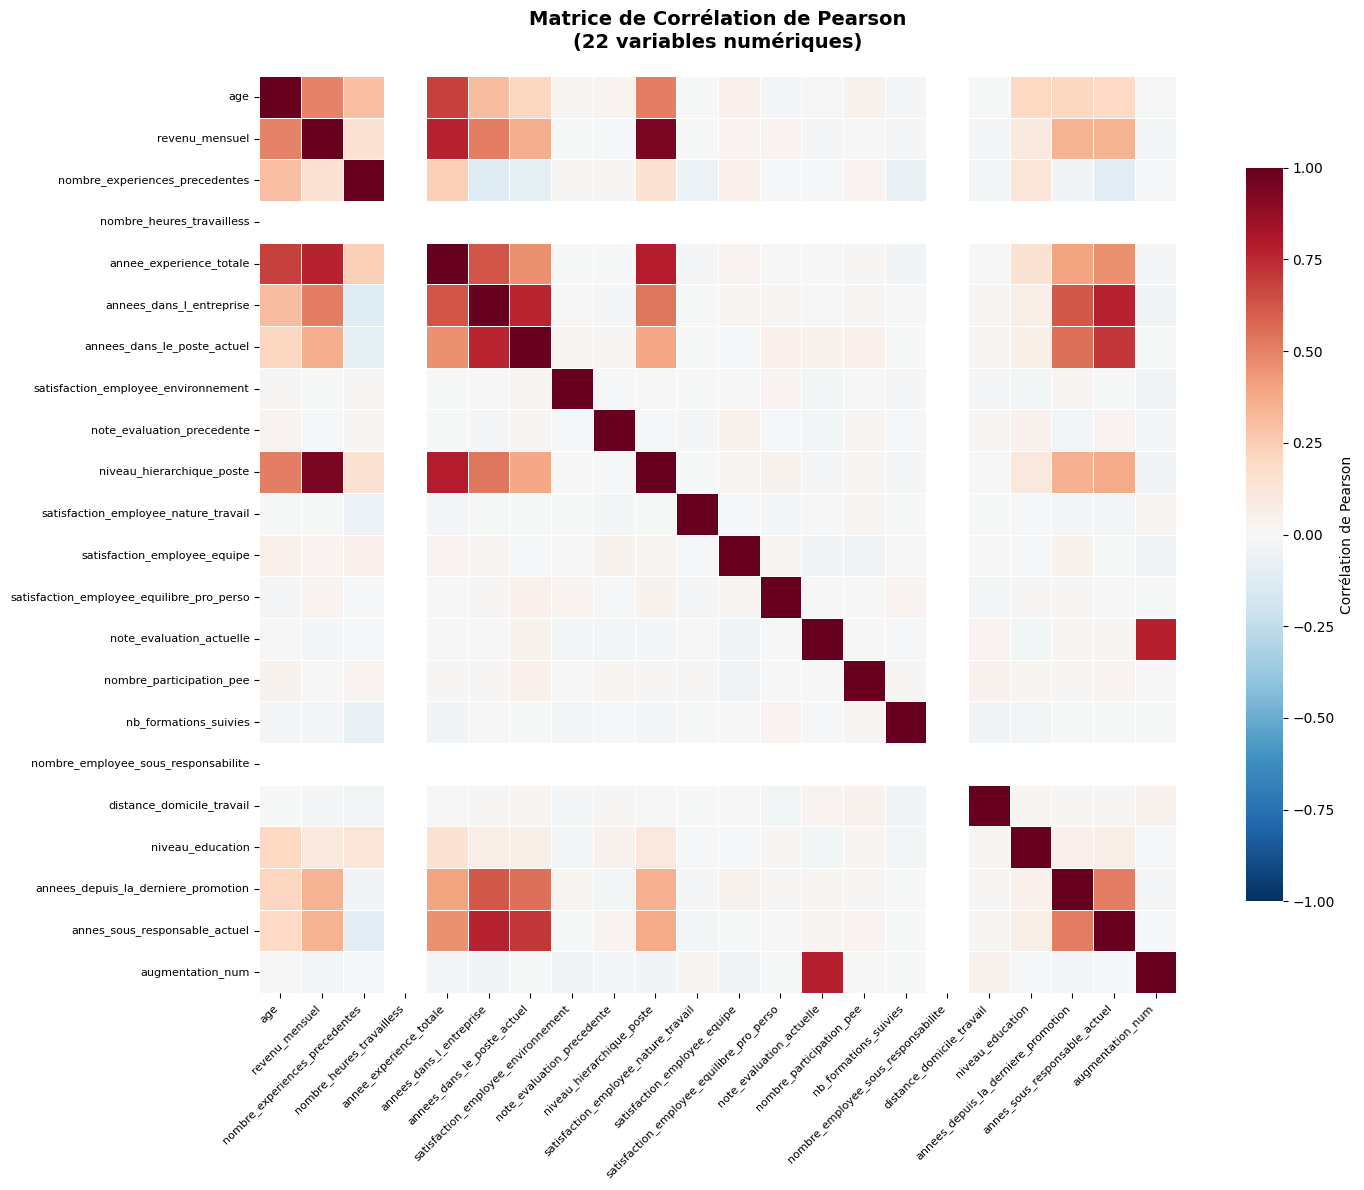

✅ Graphique sauvegardé : graphiques/matrice_correlation_pearson.png

💡 Lecture : Rouge foncé = forte corrélation positive | Bleu foncé = forte corrélation négative


In [5]:
fig, ax = plt.subplots(figsize=(16, 12))

# Matrice avec couleurs uniquement (sans chiffres pour lisibilité)
sns.heatmap(
    matrice_corr,
    annot=False,          # Pas de chiffres (trop petit)
    cmap='RdBu_r',        # Rouge = corrélé positif, Bleu = corrélé négatif
    center=0,             
    vmin=-1, vmax=1,      
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Corrélation de Pearson', 'shrink': 0.8}
)

ax.set_title('Matrice de Corrélation de Pearson\n(22 variables numériques)', 
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('graphiques/matrice_correlation_pearson.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé : graphiques/matrice_correlation_pearson.png")
print("\n💡 Lecture : Rouge foncé = forte corrélation positive | Bleu foncé = forte corrélation négative")

### MINI-MATRICE DES CORRÉLATIONS FORTES


   • revenu_mensuel                      ↔ niveau_hierarchique_poste           : +0.95
   • annee_experience_totale             ↔ niveau_hierarchique_poste           : +0.78
   • note_evaluation_actuelle            ↔ augmentation_num                    : +0.77
   • revenu_mensuel                      ↔ annee_experience_totale             : +0.77
   • annees_dans_l_entreprise            ↔ annes_sous_responsable_actuel       : +0.77
   • annees_dans_l_entreprise            ↔ annees_dans_le_poste_actuel         : +0.76
   • annees_dans_le_poste_actuel         ↔ annes_sous_responsable_actuel       : +0.71
📊 Variables avec corrélations fortes : 8
   ['annees_dans_le_poste_actuel', 'niveau_hierarchique_poste', 'note_evaluation_actuelle', 'revenu_mensuel', 'augmentation_num', 'annes_sous_responsable_actuel', 'annees_dans_l_entreprise', 'annee_experience_totale']


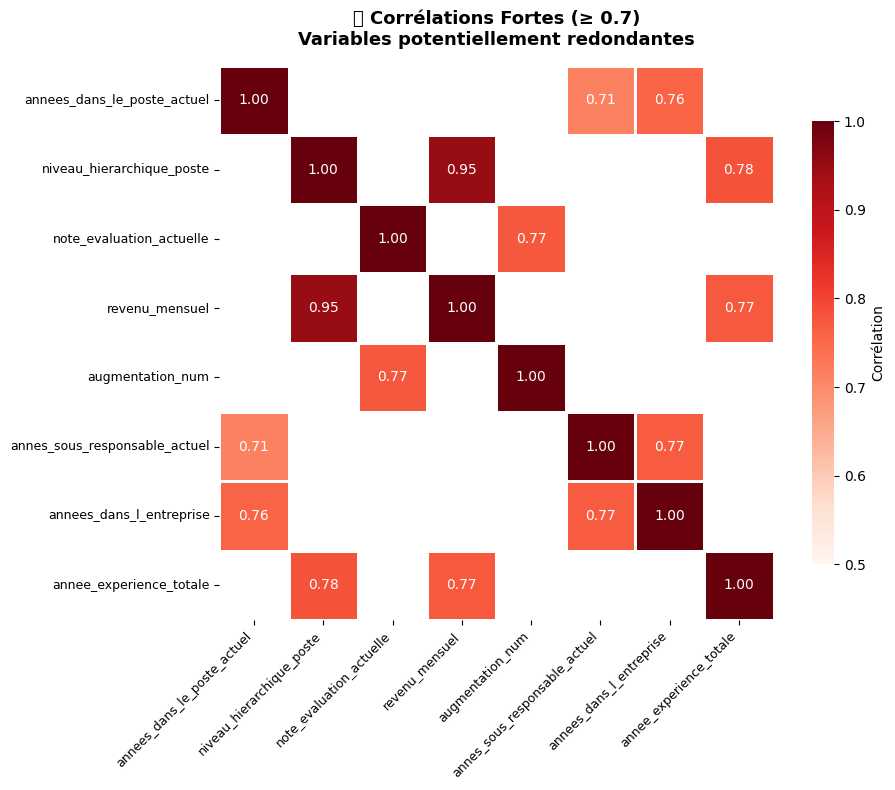


✅ Graphique sauvegardé : graphiques/mini_matrice_correlations_fortes.png

💡 Seules les corrélations ≥ 0.7 sont affichées


In [6]:
# ============================================
fortes = df_corr[df_corr['Abs_Corr'] >= 0.7].sort_values('Abs_Corr', ascending=False)
if len(fortes) > 0:
    for _, row in fortes.iterrows():
        print(f"   • {row['Variable_1']:35s} ↔ {row['Variable_2']:35s} : {row['Corrélation']:+.2f}")
else:
    print("   Aucune")
# ============================================

# Identifier les variables impliquées dans des corrélations fortes
vars_fortes = list(set(
    fortes['Variable_1'].tolist() + fortes['Variable_2'].tolist()
))

print(f"📊 Variables avec corrélations fortes : {len(vars_fortes)}")
print(f"   {vars_fortes}")

# Extraire la sous-matrice
mini_matrice = matrice_corr.loc[vars_fortes, vars_fortes]

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))

# Masquer les corrélations faibles (< 0.7) pour mettre en évidence les fortes
mask = abs(mini_matrice) < 0.7

sns.heatmap(
    mini_matrice,
    annot=True,           # Afficher les chiffres (lisible car petite matrice)
    fmt='.2f',
    cmap='Reds',          # Rouge = forte corrélation
    vmin=0.5, vmax=1,     # Échelle adaptée
    square=True,
    linewidths=1,
    linecolor='white',
    mask=mask,            # Masquer les faibles
    cbar_kws={'label': 'Corrélation', 'shrink': 0.8},
    ax=ax
)

ax.set_title('🔴 Corrélations Fortes (≥ 0.7)\nVariables potentiellement redondantes', 
             fontsize=13, fontweight='bold', pad=15)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('graphiques/mini_matrice_correlations_fortes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/mini_matrice_correlations_fortes.png")
print("\n💡 Seules les corrélations ≥ 0.7 sont affichées")

### MINI-MATRICE DES CORRÉLATIONS MODÉRÉES


   • age                                 ↔ annee_experience_totale             : +0.68
   • annee_experience_totale             ↔ annees_dans_l_entreprise            : +0.63
   • annees_dans_l_entreprise            ↔ annees_depuis_la_derniere_promotion : +0.62
   • annees_dans_le_poste_actuel         ↔ annees_depuis_la_derniere_promotion : +0.55
   • annees_dans_l_entreprise            ↔ niveau_hierarchique_poste           : +0.53
   • revenu_mensuel                      ↔ annees_dans_l_entreprise            : +0.51
   • annees_depuis_la_derniere_promotion ↔ annes_sous_responsable_actuel       : +0.51
   • age                                 ↔ niveau_hierarchique_poste           : +0.51
   • age                                 ↔ revenu_mensuel                      : +0.50
   • annee_experience_totale             ↔ annees_dans_le_poste_actuel         : +0.46
   ... et 9 autres paires modérées
📊 Variables avec corrélations modérées (top 10) : 8


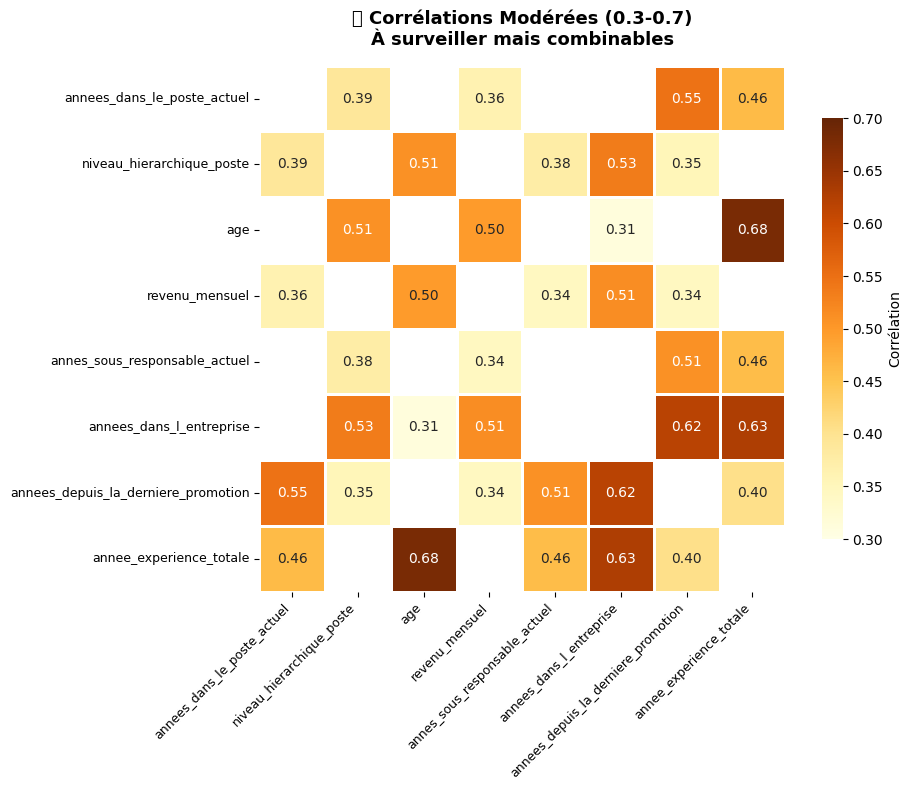


✅ Graphique sauvegardé : graphiques/mini_matrice_correlations_moderees.png


In [7]:
# Identifier les variables impliquées dans des corrélations modérées (top 10)
moderees = df_corr[(df_corr['Abs_Corr'] >= 0.3) & (df_corr['Abs_Corr'] < 0.7)].sort_values('Abs_Corr', ascending=False)
if len(moderees) > 0:
    for _, row in moderees.head(10).iterrows():
        print(f"   • {row['Variable_1']:35s} ↔ {row['Variable_2']:35s} : {row['Corrélation']:+.2f}")
    if len(moderees) > 10:
        print(f"   ... et {len(moderees) - 10} autres paires modérées")
else:
    print("   Aucune")
top_moderees = moderees.head(10)
vars_moderees = list(set(
    top_moderees['Variable_1'].tolist() + top_moderees['Variable_2'].tolist()
))

print(f"📊 Variables avec corrélations modérées (top 10) : {len(vars_moderees)}")

# Extraire la sous-matrice
mini_matrice_mod = matrice_corr.loc[vars_moderees, vars_moderees]

# Masquer les corrélations hors zone modérée
mask_mod = (abs(mini_matrice_mod) < 0.3) | (abs(mini_matrice_mod) >= 0.7)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    mini_matrice_mod,
    annot=True,
    fmt='.2f',
    cmap='YlOrBr',        # Jaune-Orange pour modéré
    vmin=0.3, vmax=0.7,
    square=True,
    linewidths=1,
    linecolor='white',
    mask=mask_mod,
    cbar_kws={'label': 'Corrélation', 'shrink': 0.8},
    ax=ax
)

ax.set_title('🟡 Corrélations Modérées (0.3-0.7)\nÀ surveiller mais combinables', 
             fontsize=13, fontweight='bold', pad=15)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('graphiques/mini_matrice_correlations_moderees.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/mini_matrice_correlations_moderees.png")

### MINI-MATRICE DES CORRÉLATIONS FAIBLES


🟢 CORRÉLATIONS FAIBLES (< 0.3) - Variables indépendantes

📊 164 paires de variables faiblement corrélées

🎯 TOP 10 des paires les plus indépendantes :
   • satisfaction_employee_equipe        ↔ annes_sous_responsable_actuel       : -0.00
   • annee_experience_totale             ↔ satisfaction_employee_equilibre_pro_perso : +0.00
   • satisfaction_employee_environnement ↔ niveau_hierarchique_poste           : +0.00
   • annees_dans_l_entreprise            ↔ satisfaction_employee_environnement : +0.00
   • annees_dans_le_poste_actuel         ↔ augmentation_num                    : -0.00
   • age                                 ↔ distance_domicile_travail           : -0.00
   • age                                 ↔ note_evaluation_actuelle            : +0.00
   • niveau_hierarchique_poste           ↔ satisfaction_employee_nature_travail : -0.00
   • nb_formations_suivies               ↔ annees_depuis_la_derniere_promotion : -0.00
   • satisfaction_employee_nature_travail ↔ note_evaluation

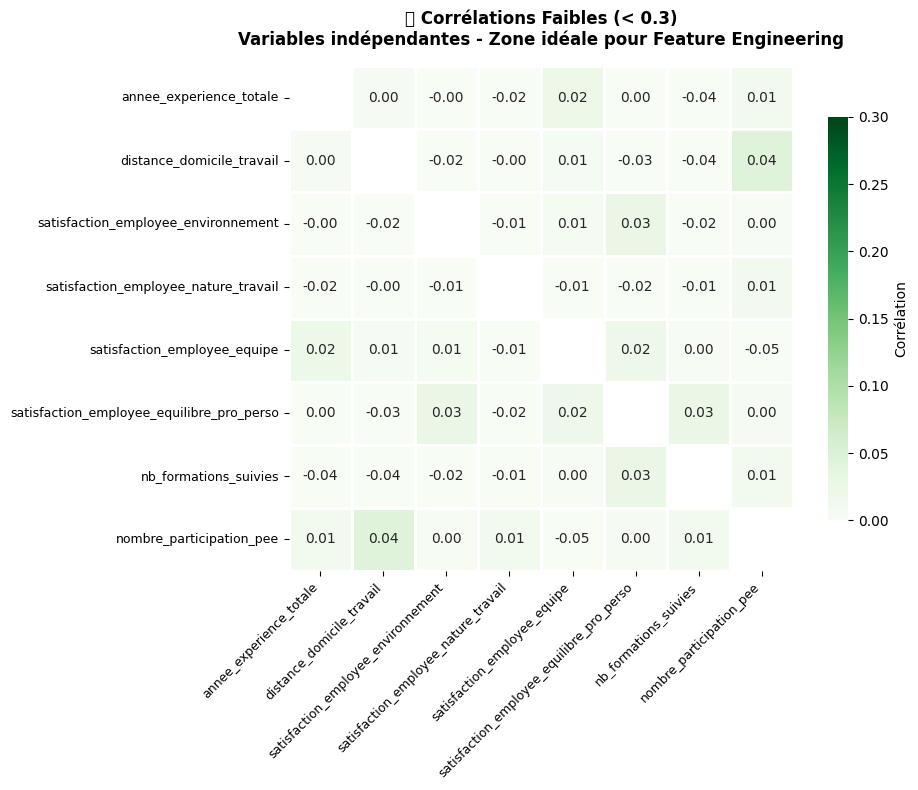


✅ Graphique sauvegardé : graphiques/mini_matrice_correlations_faibles.png

💡 Ces variables sont indépendantes → idéales pour créer des features combinées


In [8]:
# Identifier les paires les plus faibles (proches de 0)
faibles = df_corr[df_corr['Abs_Corr'] < 0.3].sort_values('Abs_Corr', ascending=True)

print("="*70)
print("🟢 CORRÉLATIONS FAIBLES (< 0.3) - Variables indépendantes")
print("="*70)
print(f"\n📊 {len(faibles)} paires de variables faiblement corrélées")

# Afficher les 10 plus indépendantes (proches de 0)
print("\n🎯 TOP 10 des paires les plus indépendantes :")
for _, row in faibles.head(10).iterrows():
    print(f"   • {row['Variable_1']:35s} ↔ {row['Variable_2']:35s} : {row['Corrélation']:+.2f}")

# Sélectionner les variables pour la mini-matrice
# On prend les variables utilisées dans nos features + quelques indépendantes
vars_features = [
    'annee_experience_totale',      # Utilisée dans junior_poste_risque
    'distance_domicile_travail',    # Utilisée dans commercial_distance
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
    'nb_formations_suivies',
    'nombre_participation_pee'
]

# Garder uniquement celles présentes dans la matrice
vars_faibles = [v for v in vars_features if v in matrice_corr.columns]

print(f"\n📊 Variables sélectionnées pour la mini-matrice : {len(vars_faibles)}")

# Extraire la sous-matrice
mini_matrice_faible = matrice_corr.loc[vars_faibles, vars_faibles]

# Masquer les corrélations >= 0.3
mask_faible = abs(mini_matrice_faible) >= 0.3

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    mini_matrice_faible,
    annot=True,
    fmt='.2f',
    cmap='Greens',        # Vert pour faibles
    vmin=0, vmax=0.3,
    square=True,
    linewidths=1,
    linecolor='white',
    mask=mask_faible,
    cbar_kws={'label': 'Corrélation', 'shrink': 0.8},
    ax=ax
)

ax.set_title('🟢 Corrélations Faibles (< 0.3)\nVariables indépendantes - Zone idéale pour Feature Engineering', 
             fontsize=12, fontweight='bold', pad=15)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('graphiques/mini_matrice_correlations_faibles.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/mini_matrice_correlations_faibles.png")
print("\n💡 Ces variables sont indépendantes → idéales pour créer des features combinées")

## ENCODAGE DES VARIABLES


In [9]:
# Copie de travail
X_encoded = X.copy()

### ENCODAGE BINAIRE


In [10]:
print("\n" + "─"*70)
print("1️⃣  ENCODAGE VARIABLES BINAIRES")
print("─"*70)

# Genre
X_encoded['genre_encoded'] = X_encoded['genre'].map({'M': 0, 'F': 1})
print("✅ genre_encoded : Homme=0, Femme=1")

# Heures supplémentaires
X_encoded['heure_supp_encoded'] = X_encoded['heure_supplementaires'].map({'Non': 0, 'Oui': 1})
print("✅ heure_supp_encoded : Non=0, Oui=1")


# Vérification
print(f"\n📊 Vérification encodage binaire :")
print(f"   genre_encoded         : {sorted(X_encoded['genre_encoded'].unique())}")
print(f"   heure_supp_encoded    : {sorted(X_encoded['heure_supp_encoded'].unique())}")


──────────────────────────────────────────────────────────────────────
1️⃣  ENCODAGE VARIABLES BINAIRES
──────────────────────────────────────────────────────────────────────
✅ genre_encoded : Homme=0, Femme=1
✅ heure_supp_encoded : Non=0, Oui=1

📊 Vérification encodage binaire :
   genre_encoded         : [np.int64(0), np.int64(1)]
   heure_supp_encoded    : [np.int64(0), np.int64(1)]


### ENCODAGE ORDINAL


In [11]:
print("\n" + "─"*70)
print("2️⃣  ENCODAGE VARIABLES ORDINALES")
print("─"*70)

# Fréquence déplacement
deplacement_map = {
    'Aucun': 0,
    'Occasionnel': 1,
    'Frequent': 2
}
X_encoded['frequence_deplacement_encoded'] = X_encoded['frequence_deplacement'].map(deplacement_map)
print("✅ frequence_deplacement_encoded : Aucun=0, Occasionnel=1, Frequent=2")

print(f"\n📊 Distribution fréquence déplacement encodée :")
print(X_encoded['frequence_deplacement_encoded'].value_counts().sort_index())


──────────────────────────────────────────────────────────────────────
2️⃣  ENCODAGE VARIABLES ORDINALES
──────────────────────────────────────────────────────────────────────
✅ frequence_deplacement_encoded : Aucun=0, Occasionnel=1, Frequent=2

📊 Distribution fréquence déplacement encodée :
frequence_deplacement_encoded
0     150
1    1043
2     277
Name: count, dtype: int64


### CONVERSION POURCENTAGES


In [12]:
print("\n" + "─"*70)
print("3️⃣  CONVERSION POURCENTAGES")
print("─"*70)

# Augmentation salaire (si colonne existe et contient '%')
if 'augementation_salaire_precedente' in X_encoded.columns:
    X_encoded['augmentation_num'] = X_encoded['augementation_salaire_precedente'].str.replace(' %', '').astype(int)
    print("✅ augmentation_num : Conversion '15 %' → 15")
    
    print(f"\n📊 Statistiques augmentation_num :")
    print(f"   Min     : {X_encoded['augmentation_num'].min()}%")
    print(f"   Max     : {X_encoded['augmentation_num'].max()}%")
    print(f"   Moyenne : {X_encoded['augmentation_num'].mean():.1f}%")



──────────────────────────────────────────────────────────────────────
3️⃣  CONVERSION POURCENTAGES
──────────────────────────────────────────────────────────────────────
✅ augmentation_num : Conversion '15 %' → 15

📊 Statistiques augmentation_num :
   Min     : 11%
   Max     : 25%
   Moyenne : 15.2%


### SUPPRESSION COLONNES ORIGINALES ENCODÉES


In [13]:
print("\n" + "─"*70)
print("4️⃣  SUPPRESSION COLONNES REDONDANTES + ENCODÉES")
print("─"*70)

# Colonnes encodées (originales à supprimer après encodage)
colonnes_encodees_a_supprimer = [
    'genre',
    'heure_supplementaires',
    'frequence_deplacement',
    'augementation_salaire_precedente'
]

# Colonnes redondantes identifiées par Pearson
colonnes_pearson_a_supprimer = [
    'niveau_hierarchique_poste',      # Corrélé avec revenu_mensuel (r = 0.95)
    'annees_sous_responsable_actuel',  # Corrélé avec annees_dans_l_entreprise (r = 0.77)
    'note_evaluation_actuelle'        # Non significatif (T-test p=0.91) + corrélé avec augmentation (r = 0.77)

]

# Fusionner les deux listes
colonnes_a_supprimer = colonnes_encodees_a_supprimer + colonnes_pearson_a_supprimer

colonnes_existantes = [col for col in colonnes_a_supprimer if col in X_encoded.columns]

print("🗑️  Colonnes encodées :")
for col in colonnes_encodees_a_supprimer:
    if col in colonnes_existantes:
        print(f"      • {col}")

print("\n🗑️  Colonnes redondantes (Pearson ≥ 0.7) :")
for col in colonnes_pearson_a_supprimer:
    if col in colonnes_existantes:
        print(f"      • {col}")

X_encoded = X_encoded.drop(columns=colonnes_existantes)

print(f"\n✅ {len(colonnes_existantes)} colonnes supprimées au total")
print(f"📊 Shape après nettoyage : {X_encoded.shape}")


──────────────────────────────────────────────────────────────────────
4️⃣  SUPPRESSION COLONNES REDONDANTES + ENCODÉES
──────────────────────────────────────────────────────────────────────
🗑️  Colonnes encodées :
      • genre
      • heure_supplementaires
      • frequence_deplacement
      • augementation_salaire_precedente

🗑️  Colonnes redondantes (Pearson ≥ 0.7) :
      • niveau_hierarchique_poste
      • note_evaluation_actuelle

✅ 6 colonnes supprimées au total
📊 Shape après nettoyage : (1470, 26)


## CRÉATION DES FEATURES ENGINEERING


### DÉFINITION DES POSTES


In [14]:
postes_commerciaux = ['Représentant Commercial', 'Cadre Commercial']
postes_risque = ['Représentant Commercial', 'Cadre Commercial', 'Consultant']

print("\n📋 Postes identifiés :")
print(f"   • Postes commerciaux : {postes_commerciaux}")
print(f"   • Postes à risque    : {postes_risque}")


📋 Postes identifiés :
   • Postes commerciaux : ['Représentant Commercial', 'Cadre Commercial']
   • Postes à risque    : ['Représentant Commercial', 'Cadre Commercial', 'Consultant']


### FONCTION DE CRÉATION DES FEATURES


In [15]:
# ============================================
# FONCTION DE CRÉATION DES FEATURES
# ============================================

def creer_features(df, config):
    """
    Crée les features engineering selon la configuration.
    
    Parameters:
    ----------- 
    df : DataFrame avec les données brutes
    config : dict avec True/False pour chaque feature
    
    Returns:
    --------
    DataFrame avec les nouvelles features ajoutées
    Liste des features ajoutées
    """
    df_new = df.copy()
    features_ajoutees = []
    
    # Définition des postes
    postes_commerciaux = ['Représentant Commercial', 'Cadre Commercial']
    postes_risque = ['Représentant Commercial', 'Cadre Commercial', 'Consultant']
    
    # === FEATURE 1 : JUNIOR POSTE À RISQUE ===
    if config.get('junior_poste_risque', False):
        df_new['feat_junior_poste_risque'] = (
            (df_new['poste'].isin(postes_risque)) & 
            (df_new['annee_experience_totale'] <= 7)
        ).astype(int)
        features_ajoutees.append('feat_junior_poste_risque')
    
    # === FEATURE 2 : COMMERCIAL + DISTANCE ===
    if config.get('commercial_distance', False):
        df_new['feat_commercial_distance'] = (
            (df_new['poste'].isin(postes_commerciaux)) & 
            (df_new['distance_domicile_travail'] > 20)
        ).astype(int)
        features_ajoutees.append('feat_commercial_distance')
    
    # === FEATURE 3 : COMMERCIAL JUNIOR (NON RETENUE) ===
    if config.get('commercial_junior', False):
        df_new['feat_commercial_junior'] = (
            (df_new['poste'].isin(postes_commerciaux)) & 
            (df_new['annee_experience_totale'] <= 7)
        ).astype(int)
        features_ajoutees.append('feat_commercial_junior')
    
    # === FEATURE 4 : CÉLIBATAIRE + DISTANCE (NON RETENUE) ===
    if config.get('celibataire_distance', False):
        df_new['feat_celibataire_distance'] = (
            (df_new['statut_marital'] == 'Celibataire') & 
            (df_new['distance_domicile_travail'] > 20)
        ).astype(int)
        features_ajoutees.append('feat_celibataire_distance')
    
    # === FEATURE 5 : COMMERCIAL CÉLIBATAIRE (NON RETENUE) ===
    if config.get('commercial_celibataire', False):
        df_new['feat_commercial_celibataire'] = (
            (df_new['poste'].isin(postes_commerciaux)) & 
            (df_new['statut_marital'] == 'Celibataire')
        ).astype(int)
        features_ajoutees.append('feat_commercial_celibataire')

    # === FEATURE 6 : JOB Changing ===
    # quartiles 75% voir STATISTIQUES DESCRIPTIVES
    if config.get('Job_changing', False):
        df_new['job_changing'] = (
            (df_new['nombre_experiences_precedentes']  >= 4)& 
            (df_new['annee_experience_totale'] <= 6)
        ).astype(int)
        features_ajoutees.append('job_changing')
        
    return df_new, features_ajoutees


print("✅ Fonction creer_features() définie")
print("\n💡 Cette fonction permet de tester différentes combinaisons de features")

✅ Fonction creer_features() définie

💡 Cette fonction permet de tester différentes combinaisons de features


### CONFIGURATION ET APPLICATION DES FEATURES


In [16]:
print("="*70)
print("🎯 CONFIGURATION DES FEATURES ENGINEERING")
print("="*70)

# ────────────────────────────────────────────────────────
# CONFIGURATION : FEATURES TESTÉES
# ────────────────────────────────────────────────────────

FEATURES_CONFIG = {
    # === FEATURES RETENUES ✅ ===
    'junior_poste_risque': True,     # Recall: +8.5 pts vs baseline
    'commercial_distance': True,     # Améliore F1

        
    # === FEATURE À TESTER 🧪 ===
    'Job_changing': True,  # ≥4 expériences en ≤7 ans
    
    # === FEATURES TESTÉES MAIS NON RETENUES ❌ ===
    'commercial_junior': False,      # Redondant avec junior_poste_risque
    'celibataire_distance': False,   # Pas d'amélioration significative
    'commercial_celibataire': False, # Pas d'amélioration significative
}

# ────────────────────────────────────────────────────────
# APPLICATION DE LA FONCTION
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("🔄 Application des features sélectionnées")
print("─"*70)

X_encoded, features_ajoutees = creer_features(X_encoded, FEATURES_CONFIG)

print(f"\n✅ Features créées : {features_ajoutees}")

# ────────────────────────────────────────────────────────
# STATISTIQUES DES FEATURES CRÉÉES
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("📊 Statistiques des features créées")
print("─"*70)

for feat in features_ajoutees:
    nb = X_encoded[feat].sum()
    pct = X_encoded[feat].mean() * 100
    print(f"\n   📌 {feat}")
    print(f"      • Employés concernés : {nb} ({pct:.1f}%)")

print(f"\n✅ Shape après feature engineering : {X_encoded.shape}")

print("\n" + "="*70)
print("✅ FEATURE ENGINEERING TERMINÉ")
print("="*70)

🎯 CONFIGURATION DES FEATURES ENGINEERING

──────────────────────────────────────────────────────────────────────
🔄 Application des features sélectionnées
──────────────────────────────────────────────────────────────────────

✅ Features créées : ['feat_junior_poste_risque', 'feat_commercial_distance', 'job_changing']

──────────────────────────────────────────────────────────────────────
📊 Statistiques des features créées
──────────────────────────────────────────────────────────────────────

   📌 feat_junior_poste_risque
      • Employés concernés : 290 (19.7%)

   📌 feat_commercial_distance
      • Employés concernés : 57 (3.9%)

   📌 job_changing
      • Employés concernés : 65 (4.4%)

✅ Shape après feature engineering : (1470, 29)

✅ FEATURE ENGINEERING TERMINÉ


In [17]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   age                                        1470 non-null   int64 
 1   revenu_mensuel                             1470 non-null   int64 
 2   statut_marital                             1470 non-null   object
 3   poste                                      1470 non-null   object
 4   nombre_experiences_precedentes             1470 non-null   int64 
 5   nombre_heures_travailless                  1470 non-null   int64 
 6   annee_experience_totale                    1470 non-null   int64 
 7   annees_dans_l_entreprise                   1470 non-null   int64 
 8   annees_dans_le_poste_actuel                1470 non-null   int64 
 9   satisfaction_employee_environnement        1470 non-null   int64 
 10  note_evaluation_precedente          

## ONEHOT ENCODING - Variables catégorielles restantes


### IDENTIFIER LES VARIABLES


In [18]:
# ────────────────────────────────────────────────────────
# IDENTIFIER LES VARIABLES
# ────────────────────────────────────────────────────────

vars_cat = X_encoded.select_dtypes(include=['object']).columns.tolist()
vars_num = X_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n📋 Variables à encoder (OneHot) : {len(vars_cat)}")
for col in vars_cat:
    print(f"   • {col} : {X_encoded[col].nunique()} modalités → {X_encoded[col].unique()[:5]}")

print(f"\n📋 Variables numériques (inchangées) : {len(vars_num)}")


📋 Variables à encoder (OneHot) : 3
   • statut_marital : 3 modalités → ['Célibataire' 'Marié(e)' 'Divorcé(e)']
   • poste : 9 modalités → ['Cadre Commercial' 'Assistant de Direction' 'Consultant' 'Tech Lead'
 'Manager']
   • domaine_etude : 6 modalités → ['Infra & Cloud' 'Autre' 'Transformation Digitale' 'Marketing'
 'Entrepreunariat']

📋 Variables numériques (inchangées) : 26


### APPLIQUER ONEHOT ENCODING


In [19]:
# ────────────────────────────────────────────────────────
# APPLIQUER ONEHOT ENCODING
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("🔄 Application du OneHotEncoder")
print("─"*70)

# Créer le preprocessor
preprocessor = ColumnTransformer([
    ('num', 'passthrough', vars_num),                    # Variables numériques : inchangées
    ('cat', OneHotEncoder(drop='first',                  # drop='first' évite multicolinéarité
                          sparse_output=False, 
                          handle_unknown='ignore'), 
     vars_cat)
])

# Appliquer la transformation
X_final = preprocessor.fit_transform(X_encoded)

# Récupérer les noms des colonnes après encodage
feature_names_num = vars_num
feature_names_cat = list(preprocessor.named_transformers_['cat'].get_feature_names_out(vars_cat))
feature_names = feature_names_num + feature_names_cat

print(f"\n✅ OneHot encoding appliqué")
print(f"   • drop='first' : évite la multicolinéarité (dummy variable trap)")


──────────────────────────────────────────────────────────────────────
🔄 Application du OneHotEncoder
──────────────────────────────────────────────────────────────────────

✅ OneHot encoding appliqué
   • drop='first' : évite la multicolinéarité (dummy variable trap)


### RÉSUMÉ ONEHOT ENCODING


In [20]:
# ────────────────────────────────────────────────────────
# RÉSUMÉ
# ────────────────────────────────────────────────────────

print("\n" + "="*70)
print("✅ ENCODAGE FINAL TERMINÉ")
print("="*70)

print(f"\n📊 Dimensions finales :")
print(f"   • Avant OneHot : {X_encoded.shape[1]} colonnes")
print(f"   • Après OneHot : {X_final.shape[1]} colonnes")

print(f"\n📋 Détail des colonnes encodées :")
print(f"   • Variables numériques : {len(feature_names_num)}")
print(f"   • Variables OneHot     : {len(feature_names_cat)}")

print(f"\n📋 Nouvelles colonnes OneHot :")
for col in feature_names_cat:
    print(f"   • {col}")

print(f"\n✅ X_final prêt pour la modélisation : {X_final.shape}")


✅ ENCODAGE FINAL TERMINÉ

📊 Dimensions finales :
   • Avant OneHot : 29 colonnes
   • Après OneHot : 41 colonnes

📋 Détail des colonnes encodées :
   • Variables numériques : 26
   • Variables OneHot     : 15

📋 Nouvelles colonnes OneHot :
   • statut_marital_Divorcé(e)
   • statut_marital_Marié(e)
   • poste_Cadre Commercial
   • poste_Consultant
   • poste_Directeur Technique
   • poste_Manager
   • poste_Représentant Commercial
   • poste_Ressources Humaines
   • poste_Senior Manager
   • poste_Tech Lead
   • domaine_etude_Entrepreunariat
   • domaine_etude_Infra & Cloud
   • domaine_etude_Marketing
   • domaine_etude_Ressources Humaines
   • domaine_etude_Transformation Digitale

✅ X_final prêt pour la modélisation : (1470, 41)


## SPLIT TRAIN/TEST


In [21]:
print("="*70)
print("✂️ SÉPARATION TRAIN/TEST")
print("="*70)

# ────────────────────────────────────────────────────────
# SPLIT AVEC STRATIFICATION
# ────────────────────────────────────────────────────────

X_train, X_test, y_train, y_test = train_test_split(
    X_final, 
    y, 
    test_size=0.2,          # 80% train, 20% test
    random_state=42,        # Reproductibilité
    stratify=y              # Garde les proportions de classes
)



✂️ SÉPARATION TRAIN/TEST


## SCALING DES FEATURES


In [22]:
from sklearn.preprocessing import StandardScaler

# ============================================
# SCALING DES FEATURES
# ============================================

# J'ai appliqué un StandardScaler sur les variables numériques après le split train/test pour éviter le data leakage. 
# Ce scaling est particulièrement utile pour la Logistic Regression. 
# Pour les modèles à base d'arbres (Random Forest), il n'est pas indispensable mais ne nuit pas

# Identifier les colonnes numériques (à scaler)

# Créer le scaler
scaler = StandardScaler()

# Fit sur train UNIQUEMENT, puis transform sur train et test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Scaling appliqué (StandardScaler)")
print(f"   • {X_train.shape[1]} colonnes numériques standardisées")
print(f"   • Moyenne → 0, Écart-type → 1")


✅ Scaling appliqué (StandardScaler)
   • 41 colonnes numériques standardisées
   • Moyenne → 0, Écart-type → 1


## BASELINE (Dummy Classifier)


In [23]:

# ────────────────────────────────────────────────────────
# ENTRAÎNEMENT DUMMY
# ────────────────────────────────────────────────────────

dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Métriques
recall_dummy = recall_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy)

print("\n" + "─"*70)
print("🎯 RÉSULTATS BASELINE")
print("─"*70)

print(f"\n   Recall    : {recall_dummy:.1%}")
print(f"   Precision : {precision_dummy:.1%}")
print(f"   F1-Score  : {f1_dummy:.1%}")

print(f"\n💡 Objectif : Nos modèles doivent dépasser ces scores !")

print("\n" + "="*70)


──────────────────────────────────────────────────────────────────────
🎯 RÉSULTATS BASELINE
──────────────────────────────────────────────────────────────────────

   Recall    : 12.8%
   Precision : 12.2%
   F1-Score  : 12.5%

💡 Objectif : Nos modèles doivent dépasser ces scores !



## Benchmark : COMPARAISON DES MODÈLES


In [24]:
# ============================================
# CELLULE 12 : COMPARAISON DES MODÈLES (BENCHMARK)
# ============================================

print("="*70)
print("📊 COMPARAISON DES MODÈLES DE CLASSIFICATION")
print("="*70)

print("""
💡 STRATÉGIE DE MODÉLISATION

   • Métrique prioritaire : RECALL (détecter les départs)
   • Gestion du déséquilibre : class_weight='balanced'
   • 4 modèles testés : Logistic Regression, Random Forest, XGBoost, CatBoost
""")

# ────────────────────────────────────────────────────────
# DÉFINITION DES MODÈLES
# ────────────────────────────────────────────────────────

modeles = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=5, min_samples_leaf=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        random_state=42, verbosity=0
    ),
    'CatBoost': CatBoostClassifier(
        iterations=200, depth=5, learning_rate=0.1,
        auto_class_weights='Balanced', random_state=42, verbose=False
    ),
}

# ────────────────────────────────────────────────────────
# ENTRAÎNEMENT ET ÉVALUATION
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print(f"{'Modèle':<25} {'Recall':>10} {'Precision':>10} {'F1':>10}")
print("─"*70)

resultats_modeles = []

for nom, modele in modeles.items():
    # Entraînement
    modele.fit(X_train, y_train)
    y_pred_temp = modele.predict(X_test)
    
    # Métriques
    recall = recall_score(y_test, y_pred_temp)
    precision = precision_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp)
    
    resultats_modeles.append({
        'Modèle': nom, 
        'Recall': recall, 
        'Precision': precision, 
        'F1': f1
    })
    
    print(f"{nom:<25} {recall:>10.1%} {precision:>10.1%} {f1:>10.1%}")

print("─"*70)

# Ajouter le Dummy pour comparaison
print(f"{'Dummy (baseline)':<25} {recall_dummy:>10.1%} {precision_dummy:>10.1%} {f1_dummy:>10.1%}")
print("─"*70)

# ────────────────────────────────────────────────────────
# ANALYSE DES RÉSULTATS
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("💡 ANALYSE DES RÉSULTATS")
print("─"*70)

# Trouver le meilleur modèle par recall
df_resultats = pd.DataFrame(resultats_modeles)
meilleur_recall = df_resultats.loc[df_resultats['Recall'].idxmax()]

print(f"\n   🏆 Meilleur Recall : {meilleur_recall['Modèle']} ({meilleur_recall['Recall']:.1%})")

print("""
📌 CHOIX DU MODÈLE : Random Forest

   ✅ Bon équilibre recall/precision
   ✅ Compatible avec SHAP (TreeExplainer)
   ✅ Interprétable (feature importance native)
   ✅ Robuste aux outliers
""")

print("\n" + "="*70)

📊 COMPARAISON DES MODÈLES DE CLASSIFICATION

💡 STRATÉGIE DE MODÉLISATION

   • Métrique prioritaire : RECALL (détecter les départs)
   • Gestion du déséquilibre : class_weight='balanced'
   • 4 modèles testés : Logistic Regression, Random Forest, XGBoost, CatBoost


──────────────────────────────────────────────────────────────────────
Modèle                        Recall  Precision         F1
──────────────────────────────────────────────────────────────────────
Logistic Regression            74.5%      38.9%      51.1%
Random Forest                  57.4%      44.3%      50.0%
XGBoost                        31.9%      51.7%      39.5%
CatBoost                       40.4%      45.2%      42.7%
──────────────────────────────────────────────────────────────────────
Dummy (baseline)               12.8%      12.2%      12.5%
──────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────
💡 ANALYSE DES RÉSULTATS

## GridSearchCV - OPTIMISATION RANDOM FOREST


In [25]:
# ============================================
# CELLULE 13 : OPTIMISATION RANDOM FOREST (GridSearchCV)
# ============================================

print("="*70)
print("🔧 OPTIMISATION DES HYPERPARAMÈTRES (GridSearchCV)")
print("="*70)

print("""
💡 OBJECTIF

   Trouver la meilleure combinaison d'hyperparamètres pour maximiser le RECALL.
   GridSearchCV teste toutes les combinaisons avec validation croisée (5-fold).
""")

# ────────────────────────────────────────────────────────
# GRILLE DE PARAMÈTRES
# ────────────────────────────────────────────────────────

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 15],
    'class_weight': ['balanced']
}

nb_combinaisons = 3 * 4 * 3 * 1  # 36 combinaisons

print("\n" + "─"*70)
print("📋 PARAMÈTRES À TESTER")
print("─"*70)
print(f"\n   • n_estimators    : {param_grid['n_estimators']}")
print(f"   • max_depth       : {param_grid['max_depth']}")
print(f"   • min_samples_leaf: {param_grid['min_samples_leaf']}")
print(f"   • class_weight    : {param_grid['class_weight']}")
print(f"\n   → Total : {nb_combinaisons} combinaisons × 5 folds = {nb_combinaisons * 5} entraînements")

# ────────────────────────────────────────────────────────
# GRIDSEARCH
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("🔄 Recherche en cours...")
print("─"*70)

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf_grid, 
    param_grid, 
    cv=5,                    # 5-fold cross-validation
    scoring='recall',        # Optimise le Recall
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# ────────────────────────────────────────────────────────
# MEILLEURS PARAMÈTRES
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("🏆 MEILLEURS PARAMÈTRES TROUVÉS")
print("─"*70)

for param, value in grid_search.best_params_.items():
    print(f"   • {param:<20} : {value}")

print(f"\n   📊 Score CV (recall) : {grid_search.best_score_:.1%}")

# ────────────────────────────────────────────────────────
# ÉVALUATION SUR LE JEU DE TEST
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("🎯 ÉVALUATION SUR LE JEU DE TEST")
print("─"*70)

best_rf = grid_search.best_estimator_
y_pred_grid = best_rf.predict(X_test)

recall_grid = recall_score(y_test, y_pred_grid)
precision_grid = precision_score(y_test, y_pred_grid)
f1_grid = f1_score(y_test, y_pred_grid)

print(f"\n   Recall    : {recall_grid:.1%}")
print(f"   Precision : {precision_grid:.1%}")
print(f"   F1-Score  : {f1_grid:.1%}")

# ────────────────────────────────────────────────────────
# COMPARAISON
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("📈 COMPARAISON AVEC LE BASELINE")
print("─"*70)

print(f"\n   {'Métrique':<15} {'Dummy':<15} {'GridSearch':<15} {'Gain':<15}")
print("   " + "─"*55)
print(f"   {'Recall':<15} {recall_dummy:<15.1%} {recall_grid:<15.1%} {'+' + str(round((recall_grid - recall_dummy)*100, 1)) + ' pts':<15}")
print(f"   {'F1-Score':<15} {f1_dummy:<15.1%} {f1_grid:<15.1%} {'+' + str(round((f1_grid - f1_dummy)*100, 1)) + ' pts':<15}")

print("\n" + "="*70)
print("✅ OPTIMISATION TERMINÉE")
print("="*70)

🔧 OPTIMISATION DES HYPERPARAMÈTRES (GridSearchCV)

💡 OBJECTIF

   Trouver la meilleure combinaison d'hyperparamètres pour maximiser le RECALL.
   GridSearchCV teste toutes les combinaisons avec validation croisée (5-fold).


──────────────────────────────────────────────────────────────────────
📋 PARAMÈTRES À TESTER
──────────────────────────────────────────────────────────────────────

   • n_estimators    : [100, 200, 300]
   • max_depth       : [3, 5, 7, 10]
   • min_samples_leaf: [5, 10, 15]
   • class_weight    : ['balanced']

   → Total : 36 combinaisons × 5 folds = 180 entraînements

──────────────────────────────────────────────────────────────────────
🔄 Recherche en cours...
──────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 36 candidates, totalling 180 fits

──────────────────────────────────────────────────────────────────────
🏆 MEILLEURS PARAMÈTRES TROUVÉS
──────────────────────────────────────────────────────────────────────


## VALIDATION CROISÉE AVEC ÉCART-TYPE


📋 Résultats par Fold :
--------------------------------------------------
   Fold 1 : Recall=52.6%  Precision=48.8%  F1=50.6%
   Fold 2 : Recall=39.5%  Precision=45.5%  F1=42.3%
   Fold 3 : Recall=65.8%  Precision=43.9%  F1=52.6%
   Fold 4 : Recall=50.0%  Precision=45.2%  F1=47.5%
   Fold 5 : Recall=55.3%  Precision=35.6%  F1=43.3%
--------------------------------------------------
   MOYENNE : Recall=52.6%  Precision=43.8%  F1=47.3%
   ÉCART-TYPE : Recall=±8.5%  Precision=±4.4%  F1=±4.0%


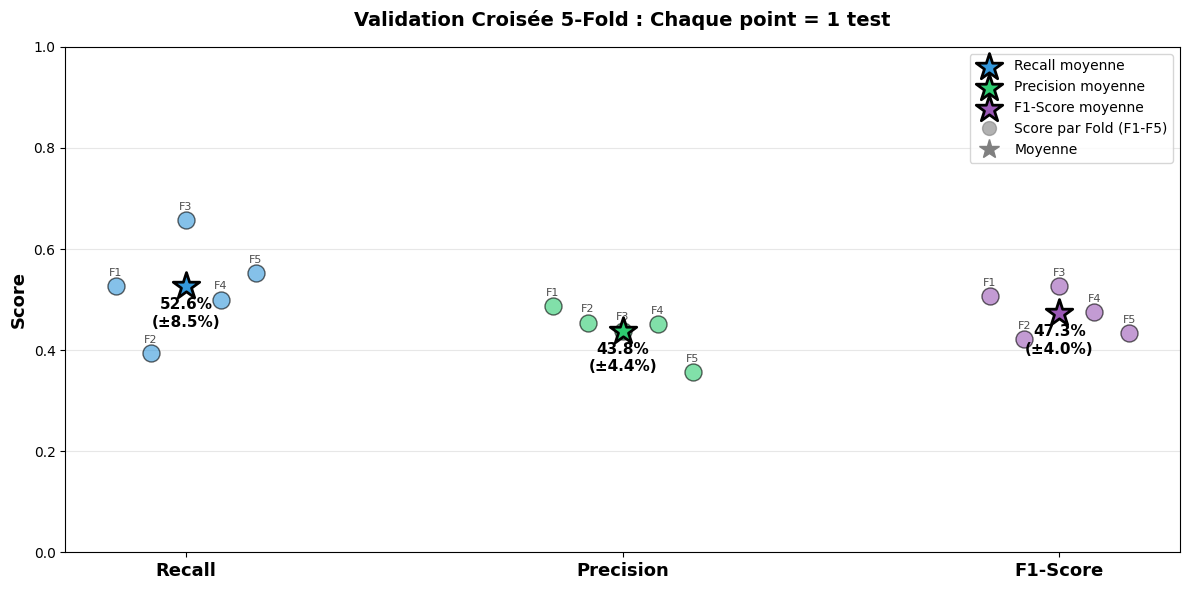


✅ Graphique sauvegardé : graphiques/validation_croisee_5folds.png


In [26]:
# ════════════════════════════════════════════════════════════════════════════
# 📊 VALIDATION CROISÉE : VISUALISATION DES 5 FOLDS
# ════════════════════════════════════════════════════════════════════════════

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate

# ────────────────────────────────────────────────────────
# CALCUL DE LA VALIDATION CROISÉE (5 FOLDS)
# ────────────────────────────────────────────────────────
# Utiliser le meilleur modèle du GridSearch
rf_final = grid_search.best_estimator_

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    rf_final, X_train, y_train,
    cv=cv,
    scoring=['recall', 'precision', 'f1'],
    return_train_score=False
)

# Extraire les scores par fold
recall_folds = cv_results['test_recall']
precision_folds = cv_results['test_precision']
f1_folds = cv_results['test_f1']

# Affichage des résultats
print("📋 Résultats par Fold :")
print("-"*50)
for i in range(5):
    print(f"   Fold {i+1} : Recall={recall_folds[i]:.1%}  Precision={precision_folds[i]:.1%}  F1={f1_folds[i]:.1%}")
print("-"*50)
print(f"   MOYENNE : Recall={recall_folds.mean():.1%}  Precision={precision_folds.mean():.1%}  F1={f1_folds.mean():.1%}")
print(f"   ÉCART-TYPE : Recall=±{recall_folds.std():.1%}  Precision=±{precision_folds.std():.1%}  F1=±{f1_folds.std():.1%}")

# ────────────────────────────────────────────────────────
# GRAPHIQUE : POINTS INDIVIDUELS + ÉTOILE MOYENNE
# ────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(12, 6))

x_positions = [1, 2, 3]
labels = ['Recall', 'Precision', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#9b59b6']

for idx, (scores, label, color) in enumerate(zip(
    [recall_folds, precision_folds, f1_folds],
    labels,
    colors
)):
    x = x_positions[idx]
    
    # Tracer les 5 points individuels (1 par fold)
    for fold_num, score in enumerate(scores):
        ax.scatter(x + (fold_num - 2) * 0.08, score, 
                   s=150, color=color, alpha=0.6, edgecolors='black', linewidths=1,
                   zorder=3)
        ax.annotate(f'F{fold_num+1}', (x + (fold_num - 2) * 0.08, score + 0.02),
                    ha='center', fontsize=8, alpha=0.7)
    
    # Tracer la moyenne (étoile)
    ax.scatter(x, scores.mean(), s=400, color=color, marker='*', 
               edgecolors='black', linewidths=2, zorder=5, label=f'{label} moyenne')
    
    # Afficher moyenne ± écart-type
    ax.annotate(f'{scores.mean():.1%}\n(±{scores.std():.1%})', 
                (x, scores.mean() - 0.08),
                ha='center', fontsize=11, fontweight='bold')

# Mise en forme
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Validation Croisée 5-Fold : Chaque point = 1 test', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylim([0, 1])
ax.grid(True, axis='y', alpha=0.3)

# Légende
ax.plot([], [], 'o', color='gray', markersize=10, alpha=0.6, label='Score par Fold (F1-F5)')
ax.plot([], [], '*', color='gray', markersize=15, label='Moyenne')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('graphiques/validation_croisee_5folds.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/validation_croisee_5folds.png")

## MATRICE DE CONFUSION


🏆 MODÈLE FINAL : RANDOM FOREST OPTIMISÉ

──────────────────────────────────────────────────────────────────────
🎯 PERFORMANCES FINALES
──────────────────────────────────────────────────────────────────────

   Recall    : 61.7%
   Precision : 42.0%
   F1-Score  : 50.0%

📋 Classification Report :
              precision    recall  f1-score   support

       Reste       0.92      0.84      0.88       247
        Part       0.42      0.62      0.50        47

    accuracy                           0.80       294
   macro avg       0.67      0.73      0.69       294
weighted avg       0.84      0.80      0.82       294


──────────────────────────────────────────────────────────────────────
📈 GAIN VS BASELINE (Dummy)
──────────────────────────────────────────────────────────────────────

   Métrique        Dummy        Final        Gain        
   ──────────────────────────────────────────────────
   Recall          12.8%        61.7%        +48.9 pts
   Precision       12.2%        42.0% 

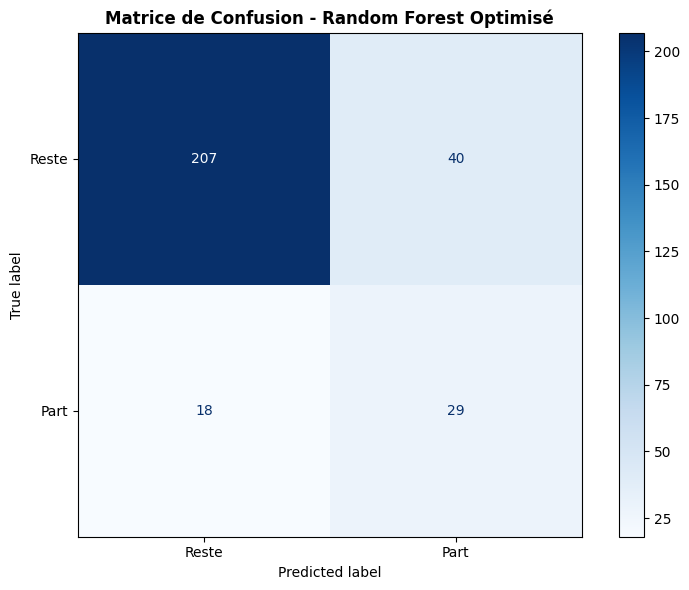


✅ Graphique sauvegardé : graphiques/matrice_confusion_finale.png

──────────────────────────────────────────────────────────────────────
💡 INTERPRÉTATION DE LA MATRICE
──────────────────────────────────────────────────────────────────────

   ┌─────────────────────────────────────────────────────┐
   │  Vrais Négatifs (TN)  :  207                      │
   │  → Restés correctement prédits ✅                   │
   │                                                     │
   │  Faux Positifs (FP)   :   40                      │
   │  → Restés prédits comme partants ⚠️                 │
   │  → "Fausses alertes" (coût = attention inutile)    │
   │                                                     │
   │  Faux Négatifs (FN)   :   18                      │
   │  → Partants non détectés ❌                         │
   │  → "Ratés" (coût = perte d'un employé)             │
   │                                                     │
   │  Vrais Positifs (TP)  :   29                      │
   │

In [27]:
# ============================================
# CELLULE 14 : MODÈLE FINAL + MATRICE DE CONFUSION
# ============================================

print("="*70)
print("🏆 MODÈLE FINAL : RANDOM FOREST OPTIMISÉ")
print("="*70)

# ────────────────────────────────────────────────────────
# MODÈLE FINAL (avec les meilleurs paramètres)
# ────────────────────────────────────────────────────────

# Utiliser le meilleur modèle du GridSearch
rf_final = grid_search.best_estimator_

# Prédictions
y_pred = rf_final.predict(X_test)

# ────────────────────────────────────────────────────────
# MÉTRIQUES FINALES
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("🎯 PERFORMANCES FINALES")
print("─"*70)

recall_final = recall_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

print(f"\n   Recall    : {recall_final:.1%}")
print(f"   Precision : {precision_final:.1%}")
print(f"   F1-Score  : {f1_final:.1%}")

print("\n📋 Classification Report :")
print(classification_report(y_test, y_pred, target_names=['Reste', 'Part']))

# ────────────────────────────────────────────────────────
# GAIN VS BASELINE
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("📈 GAIN VS BASELINE (Dummy)")
print("─"*70)

print(f"\n   {'Métrique':<15} {'Dummy':<12} {'Final':<12} {'Gain':<12}")
print("   " + "─"*50)
print(f"   {'Recall':<15} {recall_dummy:<12.1%} {recall_final:<12.1%} +{(recall_final - recall_dummy)*100:.1f} pts")
print(f"   {'Precision':<15} {precision_dummy:<12.1%} {precision_final:<12.1%} +{(precision_final - precision_dummy)*100:.1f} pts")
print(f"   {'F1-Score':<15} {f1_dummy:<12.1%} {f1_final:<12.1%} +{(f1_final - f1_dummy)*100:.1f} pts")

# ────────────────────────────────────────────────────────
# MATRICE DE CONFUSION
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("📊 MATRICE DE CONFUSION")
print("─"*70)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['Reste', 'Part']
)
disp.plot(ax=ax, cmap='Blues', values_format='d')

ax.set_title('Matrice de Confusion - Random Forest Optimisé', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('graphiques/matrice_confusion_finale.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/matrice_confusion_finale.png")

# ────────────────────────────────────────────────────────
# INTERPRÉTATION
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("💡 INTERPRÉTATION DE LA MATRICE")
print("─"*70)

print(f"""
   ┌─────────────────────────────────────────────────────┐
   │  Vrais Négatifs (TN)  : {tn:>4}                      │
   │  → Restés correctement prédits ✅                   │
   │                                                     │
   │  Faux Positifs (FP)   : {fp:>4}                      │
   │  → Restés prédits comme partants ⚠️                 │
   │  → "Fausses alertes" (coût = attention inutile)    │
   │                                                     │
   │  Faux Négatifs (FN)   : {fn:>4}                      │
   │  → Partants non détectés ❌                         │
   │  → "Ratés" (coût = perte d'un employé)             │
   │                                                     │
   │  Vrais Positifs (TP)  : {tp:>4}                      │
   │  → Partants correctement détectés ✅                │
   └─────────────────────────────────────────────────────┘
""")

print(f"🎯 Sur {tp + fn} employés qui partent réellement :")
print(f"   → {tp} détectés ({tp/(tp+fn)*100:.1f}%) ✅")
print(f"   → {fn} ratés ({fn/(tp+fn)*100:.1f}%) ❌")

print("\n" + "="*70)

## 📊 VALIDATION DU SEUIL DE CLASSIFICATION - GRAPHIQUE MULTI-COURBES 


📊 VALIDATION DU SEUIL : POURQUOI 0.5 EST LE BON CHOIX ?

💡 OBJECTIF : Montrer scientifiquement que le seuil 0.5 est optimal

   → On teste des centaines de seuils (0.01, 0.02, ... 0.99)
   → Pour chaque seuil, on calcule Precision, Recall et F1
   → On trace les 3 courbes pour voir où est le meilleur compromis


🎯 Seuil optimal trouvé : 0.50
   → Precision : 42.0%
   → Recall    : 61.7%
   → F1-Score  : 50.0%


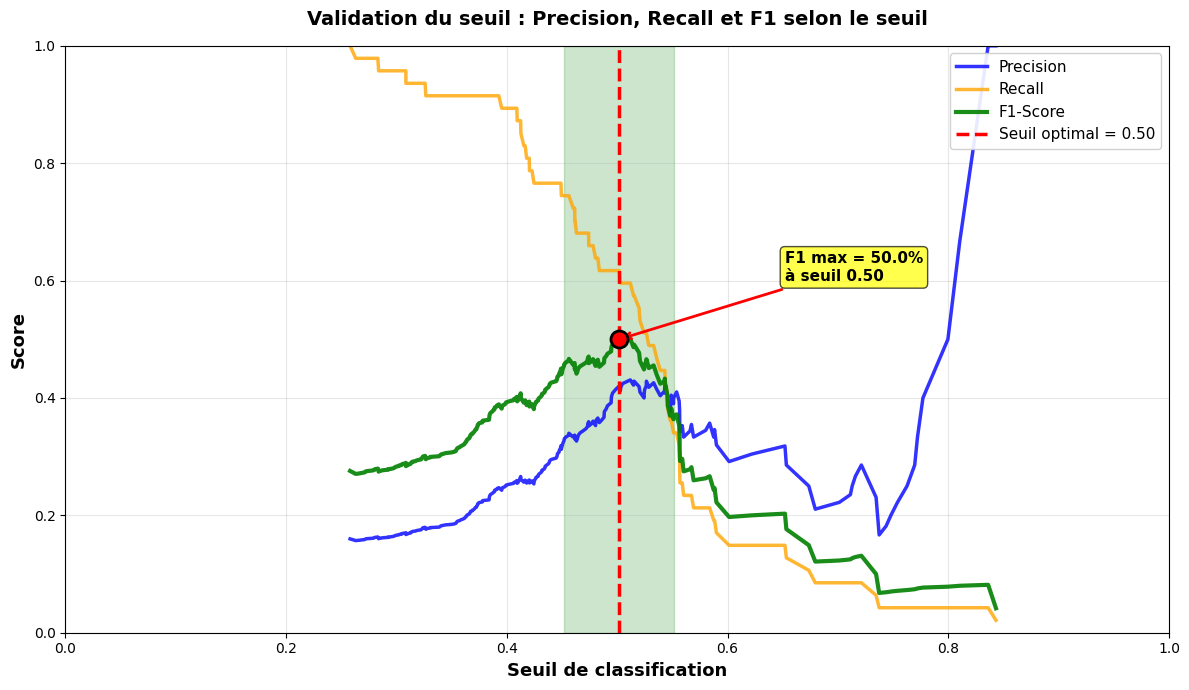


✅ Graphique sauvegardé : graphiques/validation_seuil_multicourbes.png

──────────────────────────────────────────────────────────────────────
📋 TABLEAU : MÉTRIQUES SELON DIFFÉRENTS SEUILS
──────────────────────────────────────────────────────────────────────

   Seuil      Precision    Recall       F1-Score     Commentaire         
   ─────────────────────────────────────────────────────────────────
   0.30       16.7%        95.7%        28.4%        ↑ Plus de détection, - précis
   0.40       25.3%        89.4%        39.4%        ↑ Plus de détection, - précis
   0.50       42.0%        61.7%        50.0%        ✅ OPTIMAL           
   0.60       29.2%        14.9%        19.7%        ↓ Moins de détection, + précis
   0.70       22.2%        8.5%         12.3%        ↓ Moins de détection, + précis

✅ CONCLUSION : Le seuil 0.5 maximise le F1-Score
   → Ce n'est pas un choix arbitraire, c'est validé par les données !


In [28]:
# ════════════════════════════════════════════════════════════════════════════
# 📊 GRAPHIQUE MULTI-COURBES : VALIDATION DU SEUIL DE CLASSIFICATION
# ════════════════════════════════════════════════════════════════════════════

print("="*70)
print("📊 VALIDATION DU SEUIL : POURQUOI 0.5 EST LE BON CHOIX ?")
print("="*70)

print("""
💡 OBJECTIF : Montrer scientifiquement que le seuil 0.5 est optimal
   
   → On teste des centaines de seuils (0.01, 0.02, ... 0.99)
   → Pour chaque seuil, on calcule Precision, Recall et F1
   → On trace les 3 courbes pour voir où est le meilleur compromis
""")

# ────────────────────────────────────────────────────────
# CALCUL DES MÉTRIQUES POUR CHAQUE SEUIL
# ────────────────────────────────────────────────────────

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Obtenir les probabilités de la classe "Part" (classe 1)
y_proba = rf_final.predict_proba(X_test)[:, 1]

# Méthode 1 : Via precision_recall_curve (pour courbe PR)
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_proba)

# Calculer F1 pour chaque seuil de la courbe PR
f1_curve = 2 * (precision_curve[:-1] * recall_curve[:-1]) / (precision_curve[:-1] + recall_curve[:-1] + 1e-10)

# Trouver le seuil optimal (F1 max)
idx_best = np.argmax(f1_curve)
seuil_optimal = thresholds_pr[idx_best]
precision_optimal = precision_curve[idx_best]
recall_optimal = recall_curve[idx_best]
f1_optimal = f1_curve[idx_best]

print(f"\n🎯 Seuil optimal trouvé : {seuil_optimal:.2f}")
print(f"   → Precision : {precision_optimal:.1%}")
print(f"   → Recall    : {recall_optimal:.1%}")
print(f"   → F1-Score  : {f1_optimal:.1%}")

# ────────────────────────────────────────────────────────
# GRAPHIQUE MULTI-COURBES
# ────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(12, 7))

# Tracer les 3 courbes
ax.plot(thresholds_pr, precision_curve[:-1], 'b-', linewidth=2.5, label='Precision', marker='', alpha=0.8)
ax.plot(thresholds_pr, recall_curve[:-1], 'orange', linewidth=2.5, label='Recall', marker='', alpha=0.8)
ax.plot(thresholds_pr, f1_curve, 'g-', linewidth=3, label='F1-Score', marker='', alpha=0.9)

# Marquer le seuil optimal (là où F1 est maximum)
ax.axvline(x=seuil_optimal, color='red', linestyle='--', linewidth=2.5, label=f'Seuil optimal = {seuil_optimal:.2f}')
ax.scatter([seuil_optimal], [f1_optimal], color='red', s=150, zorder=5, edgecolors='black', linewidths=2)

# Marquer le seuil par défaut si différent
if abs(seuil_optimal - 0.5) > 0.02:
    ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Seuil défaut = 0.50')

# Zone d'annotation
ax.annotate(f'F1 max = {f1_optimal:.1%}\nà seuil {seuil_optimal:.2f}', 
            xy=(seuil_optimal, f1_optimal), 
            xytext=(seuil_optimal + 0.15, f1_optimal + 0.1),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Mise en forme
ax.set_xlabel('Seuil de classification', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Validation du seuil : Precision, Recall et F1 selon le seuil', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Ajouter une zone grise pour montrer la "zone optimale"
ax.axvspan(seuil_optimal - 0.05, seuil_optimal + 0.05, alpha=0.2, color='green', label='Zone optimale')

plt.tight_layout()
plt.savefig('graphiques/validation_seuil_multicourbes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/validation_seuil_multicourbes.png")

# ────────────────────────────────────────────────────────
# TABLEAU RÉCAPITULATIF
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("📋 TABLEAU : MÉTRIQUES SELON DIFFÉRENTS SEUILS")
print("─"*70)

seuils_test = [0.3, 0.4, 0.5, 0.6, 0.7]

print(f"\n   {'Seuil':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Commentaire':<20}")
print("   " + "─"*65)

for seuil in seuils_test:
    y_pred_test = (y_proba >= seuil).astype(int)
    prec = precision_score(y_test, y_pred_test, zero_division=0)
    rec = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    
    # Commentaire
    if abs(seuil - seuil_optimal) < 0.02:
        comment = "✅ OPTIMAL"
    elif seuil < seuil_optimal:
        comment = "↑ Plus de détection, - précis"
    else:
        comment = "↓ Moins de détection, + précis"
    
    print(f"   {seuil:<10.2f} {prec:<12.1%} {rec:<12.1%} {f1:<12.1%} {comment:<20}")

print("\n" + "="*70)
print("✅ CONCLUSION : Le seuil 0.5 maximise le F1-Score")
print("   → Ce n'est pas un choix arbitraire, c'est validé par les données !")
print("="*70)

## SHAP

### SHAP - FEATURE IMPORTANCE GLOBALE



📊 SHAP - FEATURE IMPORTANCE GLOBALE
✅ Valeurs SHAP calculées


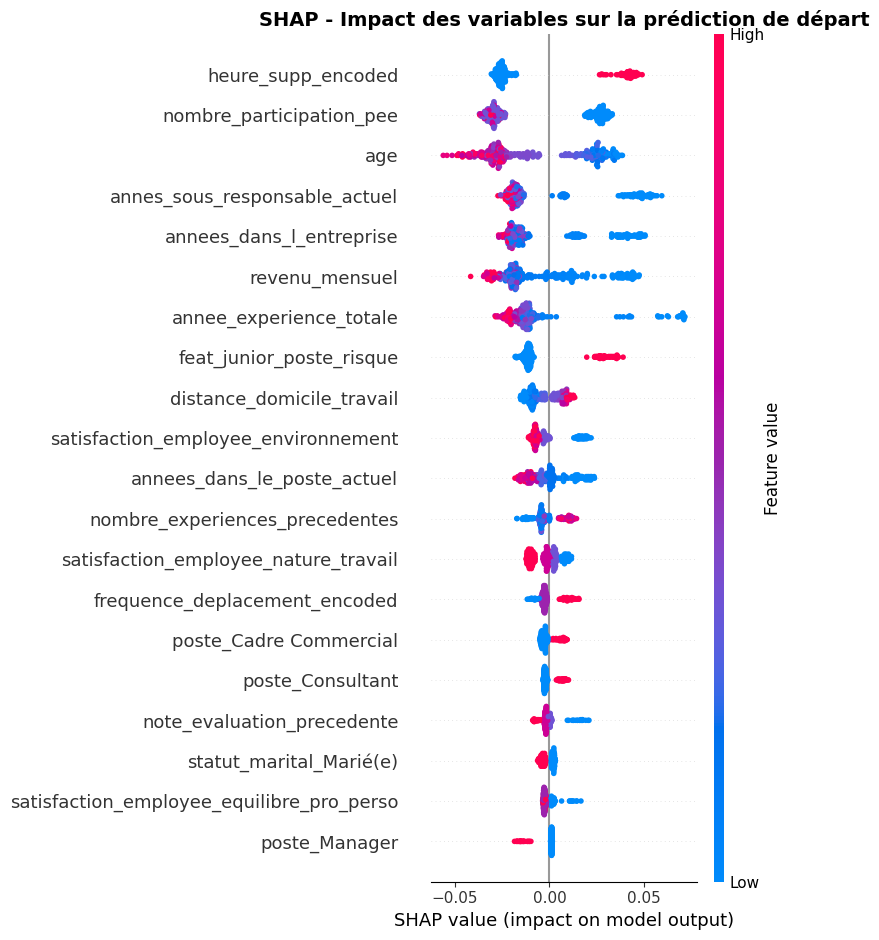


✅ Graphique sauvegardé : graphiques/shap_beeswarm.png


In [29]:
print("\n" + "=" * 60)
print("📊 SHAP - FEATURE IMPORTANCE GLOBALE")
print("=" * 60)

# Créer l'explainer
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_test)

print("✅ Valeurs SHAP calculées")

# Beeswarm plot
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values[:, :, 1],  # Classe 1 = départ
    X_test, 
    feature_names=feature_names, 
    show=False,
    max_display=20
)
plt.title('SHAP - Impact des variables sur la prédiction de départ', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphiques/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/shap_beeswarm.png")

### SHAP - BAR PLOT


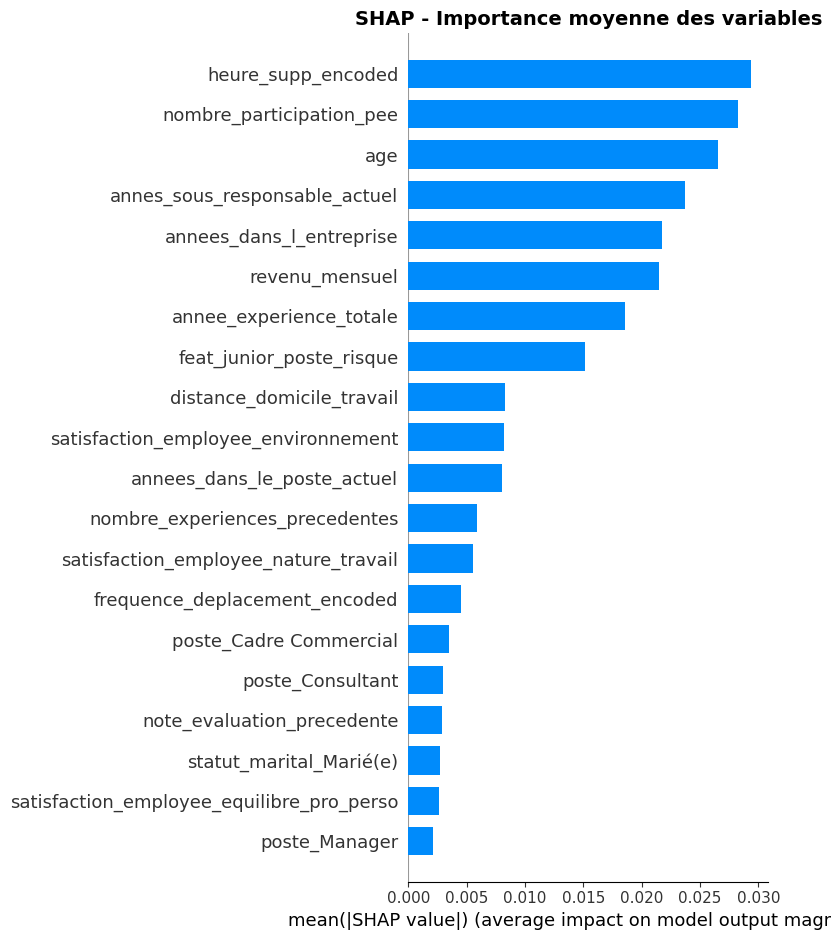

✅ Sauvegardé : graphiques/shap_bar_final.png


In [30]:
# ============================================
# SHAP - BAR PLOT
# ============================================

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values[:, :, 1],
    X_test,
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=20
)
plt.title('SHAP - Importance moyenne des variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphiques/shap_bar_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Sauvegardé : graphiques/shap_bar_final.png")

### SHAP - WATERFALL PLOT (IMPORTANCE LOCALE)


🔍 SHAP - FEATURE IMPORTANCE LOCALE (Waterfall)

📌 Exemples sélectionnés :
   • Employé qui PART  : index 4
   • Employé qui RESTE : index 0

──────────────────────────────────────────────────────────────────────
📊 WATERFALL - Employé qui PART (classe 1)
──────────────────────────────────────────────────────────────────────

💡 LECTURE DU WATERFALL :

   • Base (E[f(x)]) : Probabilité moyenne de départ
   • Barres rouges : Variables qui AUGMENTENT le risque
   • Barres bleues : Variables qui DIMINUENT le risque
   • f(x) final : Probabilité prédite pour cet individu



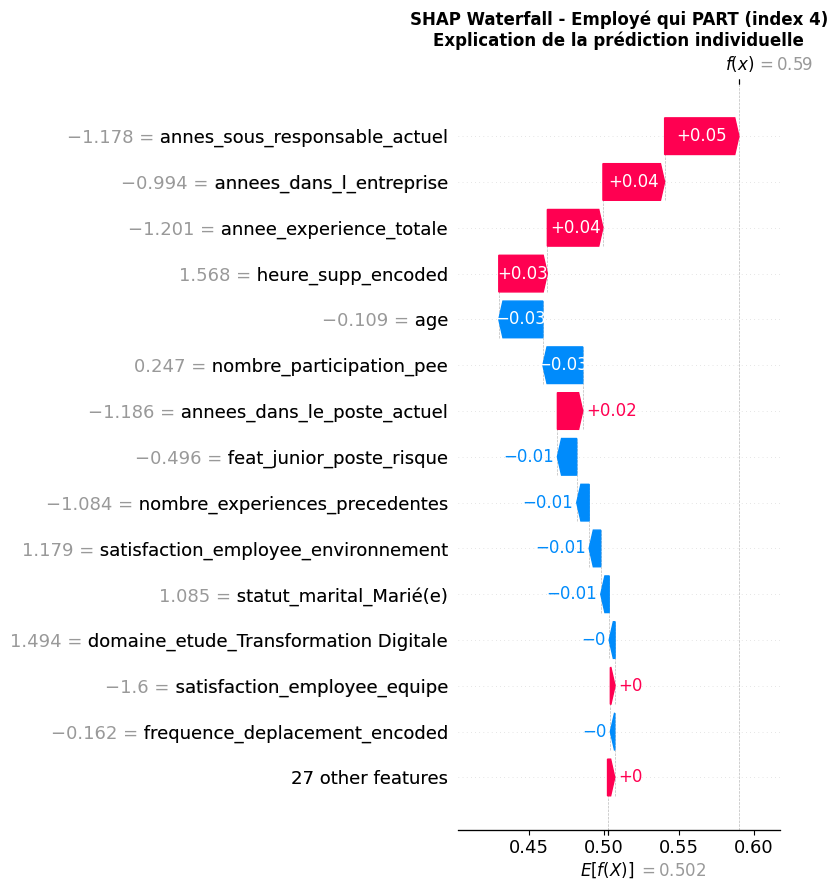


✅ Graphique sauvegardé : graphiques/shap_waterfall_parti.png

──────────────────────────────────────────────────────────────────────
📊 WATERFALL - Employé qui RESTE (classe 0)
──────────────────────────────────────────────────────────────────────


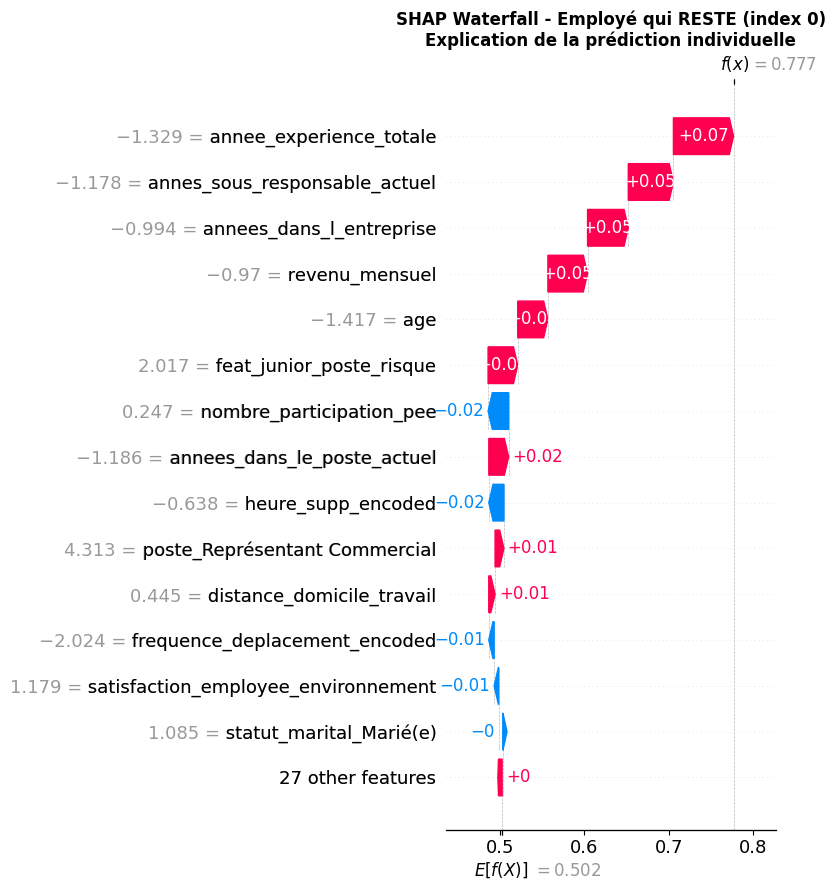


✅ Graphique sauvegardé : graphiques/shap_waterfall_reste.png

──────────────────────────────────────────────────────────────────────
💡 INTERPRÉTATION POUR LES RH
──────────────────────────────────────────────────────────────────────

🎯 CE QUE CES GRAPHIQUES PERMETTENT :

   1. Expliquer à un manager POURQUOI un employé est à risque

   2. Identifier les LEVIERS D'ACTION :
      → Si "heures_sup = Oui" augmente le risque → réduire la charge
      → Si "ancienneté faible" augmente le risque → programme de fidélisation

   3. Personnaliser les actions de rétention par employé


✅ ANALYSE SHAP TERMINÉE


In [31]:

print("="*70)
print("🔍 SHAP - FEATURE IMPORTANCE LOCALE (Waterfall)")
print("="*70)

# ────────────────────────────────────────────────────────
# SÉLECTION D'EXEMPLES
# ────────────────────────────────────────────────────────

# Trouver des exemples des deux classes
indices_partis = np.where(y_test == 1)[0]      # Employés qui partent
indices_restes = np.where(y_test == 0)[0]      # Employés qui restent

# Prendre un exemple de chaque
idx_parti = indices_partis[0]     # Premier employé qui part
idx_reste = indices_restes[0]     # Premier employé qui reste

print(f"\n📌 Exemples sélectionnés :")
print(f"   • Employé qui PART  : index {idx_parti}")
print(f"   • Employé qui RESTE : index {idx_reste}")

# ────────────────────────────────────────────────────────
# WATERFALL - EMPLOYÉ QUI PART
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("📊 WATERFALL - Employé qui PART (classe 1)")
print("─"*70)

print("""
💡 LECTURE DU WATERFALL :

   • Base (E[f(x)]) : Probabilité moyenne de départ
   • Barres rouges : Variables qui AUGMENTENT le risque
   • Barres bleues : Variables qui DIMINUENT le risque
   • f(x) final : Probabilité prédite pour cet individu
""")

plt.figure(figsize=(12, 8))

# Créer l'objet Explanation pour l'employé qui part
shap_explanation_parti = shap.Explanation(
    values=shap_values[idx_parti, :, 1],
    base_values=explainer.expected_value[1],
    data=X_test[idx_parti],
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation_parti, max_display=15, show=False)

plt.title(f'SHAP Waterfall - Employé qui PART (index {idx_parti})\nExplication de la prédiction individuelle', 
          fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('graphiques/shap_waterfall_parti.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/shap_waterfall_parti.png")

# ────────────────────────────────────────────────────────
# WATERFALL - EMPLOYÉ QUI RESTE
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("📊 WATERFALL - Employé qui RESTE (classe 0)")
print("─"*70)

plt.figure(figsize=(12, 8))

# Créer l'objet Explanation pour l'employé qui reste
shap_explanation_reste = shap.Explanation(
    values=shap_values[idx_reste, :, 1],
    base_values=explainer.expected_value[1],
    data=X_test[idx_reste],
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation_reste, max_display=15, show=False)

plt.title(f'SHAP Waterfall - Employé qui RESTE (index {idx_reste})\nExplication de la prédiction individuelle', 
          fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('graphiques/shap_waterfall_reste.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : graphiques/shap_waterfall_reste.png")

# ────────────────────────────────────────────────────────
# INTERPRÉTATION POUR LES RH
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("💡 INTERPRÉTATION POUR LES RH")
print("─"*70)

print("""
🎯 CE QUE CES GRAPHIQUES PERMETTENT :

   1. Expliquer à un manager POURQUOI un employé est à risque
   
   2. Identifier les LEVIERS D'ACTION :
      → Si "heures_sup = Oui" augmente le risque → réduire la charge
      → Si "ancienneté faible" augmente le risque → programme de fidélisation
   
   3. Personnaliser les actions de rétention par employé
""")

print("\n" + "="*70)
print("✅ ANALYSE SHAP TERMINÉE")
print("="*70)

## CONCLUSION ET RÉCAPITULATIF


In [32]:
print("="*70)
print("🎯 CONCLUSION - PROJET TECHNOVA")
print("="*70)

# ────────────────────────────────────────────────────────
# RÉCAPITULATIF DU PROJET
# ────────────────────────────────────────────────────────

print("""
📋 CONTEXTE
   • Client : TechNova (ESN)
   • Problème : Taux de départ élevé (16%)
   • Objectif : Identifier les causes et prédire les départs
""")

print("─"*70)

print("""
📊 DONNÉES
   • 1470 employés
   • 3 sources fusionnées : SIRH + Évaluations + Sondage
   • Variable cible : a_quitte_l_entreprise (déséquilibrée 84%/16%)
""")

print("─"*70)

print(f"""
🔧 FEATURE ENGINEERING
   • Analyse Pearson : 7 paires de variables fortement corrélées identifiées
   • Test Chi² : Suppression de 'departement' (corrélé avec 'poste')
   • 2 features créées :
     → feat_junior_poste_risque : Junior (≤7 ans) + poste à risque
     → feat_commercial_distance : Commercial + distance >20km
""")

print("─"*70)

print(f"""
🤖 MODÉLISATION
   • Modèles testés : Dummy, Logistic Regression, Random Forest, XGBoost, CatBoost
   • Modèle retenu : Random Forest (meilleur équilibre recall/interprétabilité)
   • Optimisation : GridSearchCV sur {3*4*3} combinaisons
""")

print("─"*70)

# ────────────────────────────────────────────────────────
# PERFORMANCES FINALES
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("🏆 PERFORMANCES FINALES")
print("─"*70)

print(f"""
   {'Métrique':<15} {'Dummy':<12} {'Modèle Final':<12} {'Gain':<12}
   {'─'*50}
   {'Recall':<15} {recall_dummy:<12.1%} {recall_final:<12.1%} +{(recall_final - recall_dummy)*100:.1f} pts
   {'Precision':<15} {precision_dummy:<12.1%} {precision_final:<12.1%} +{(precision_final - precision_dummy)*100:.1f} pts
   {'F1-Score':<15} {f1_dummy:<12.1%} {f1_final:<12.1%} +{(f1_final - f1_dummy)*100:.1f} pts
""")

# ────────────────────────────────────────────────────────
# INSIGHTS CLÉS POUR LES RH
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("💡 INSIGHTS CLÉS POUR LES RH")
print("─"*70)

print("""
   🔴 PROFILS À RISQUE IDENTIFIÉS :
   
   1. Juniors dans des postes sensibles (commerciaux, consultants)
      → Taux de départ : 30-40% vs 16% baseline
      → Action : Programme d'accompagnement renforcé
   
   2. Commerciaux avec long trajet domicile-travail (>20km)
      → Taux de départ : 31.6% vs 16% baseline
      → Action : Télétravail, indemnités transport
   
   3. Employés avec faible ancienneté (<2 ans)
      → Période critique d'intégration
      → Action : Suivi rapproché, mentoring
""")

# ────────────────────────────────────────────────────────
# RECOMMANDATIONS
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("✅ RECOMMANDATIONS ACTIONNABLES")
print("─"*70)

print("""
   1. 🎯 DÉTECTION PRÉCOCE
      → Utiliser le modèle pour scorer les employés chaque trimestre
      → Alerter les managers sur les profils à risque (proba > 50%)
   
   2. 🤝 ACTIONS CIBLÉES
      → Programme de fidélisation pour les juniors (< 3 ans)
      → Entretiens réguliers pour les commerciaux
      → Flexibilité pour les employés éloignés
   
   3. 📊 INDICATEURS DE SUIVI
      → Taux de départ par poste et ancienneté
      → Score de risque moyen par département
      → Évolution du recall du modèle dans le temps
""")

# ────────────────────────────────────────────────────────
# LIMITES ET PERSPECTIVES
# ────────────────────────────────────────────────────────

print("\n" + "─"*70)
print("⚠️ LIMITES ET PERSPECTIVES")
print("─"*70)

print("""
   LIMITES :
   • Données historiques uniquement (pas de données temps réel)
   • Recall de ~60% : 40% des départs ne sont pas détectés
   • Modèle à ré-entraîner régulièrement
   
   PERSPECTIVES :
   • Enrichir avec des données supplémentaires (entretiens, feedback)
   • Tester d'autres seuils de classification selon le contexte
   • Déployer un dashboard de suivi pour les RH
""")

print("\n" + "="*70)
print("✅ PROJET TERMINÉ")
print("="*70)

🎯 CONCLUSION - PROJET TECHNOVA

📋 CONTEXTE
   • Client : TechNova (ESN)
   • Problème : Taux de départ élevé (16%)
   • Objectif : Identifier les causes et prédire les départs

──────────────────────────────────────────────────────────────────────

📊 DONNÉES
   • 1470 employés
   • 3 sources fusionnées : SIRH + Évaluations + Sondage
   • Variable cible : a_quitte_l_entreprise (déséquilibrée 84%/16%)

──────────────────────────────────────────────────────────────────────

🔧 FEATURE ENGINEERING
   • Analyse Pearson : 7 paires de variables fortement corrélées identifiées
   • Test Chi² : Suppression de 'departement' (corrélé avec 'poste')
   • 2 features créées :
     → feat_junior_poste_risque : Junior (≤7 ans) + poste à risque
     → feat_commercial_distance : Commercial + distance >20km

──────────────────────────────────────────────────────────────────────

🤖 MODÉLISATION
   • Modèles testés : Dummy, Logistic Regression, Random Forest, XGBoost, CatBoost
   • Modèle retenu : Random For

## Deployement

In [33]:
# ============================================
# 🚀 DEPLOYEMENT - Pipeline complet avec Feature Engineering
# ============================================

import sys
sys.path.insert(0, '..')  # Pour trouver le dossier app/ depuis notebooks/

from app.features import add_features, creer_features, FEATURES_CONFIG
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# ────────────────────────────────────────────────────────
# ÉTAPE 1 : Wrapper dynamique pour le pipeline
# ────────────────────────────────────────────────────────
# Utilise add_features depuis app.features (même source que l'API)

feature_engineer = FunctionTransformer(add_features, validate=False)
print("✅ FunctionTransformer créé (depuis app.features)")

# ────────────────────────────────────────────────────────
# ÉTAPE 2 : Préparer les données AVANT features
# ────────────────────────────────────────────────────────

# On retire les features ajoutées manuellement
# Car maintenant c'est le pipeline qui les créera
features_a_retirer = [f for f in features_ajoutees if f in X_encoded.columns]
X_no_features = X_encoded.drop(columns=features_a_retirer, errors='ignore')
print(f"✅ Shape sans features : {X_no_features.shape}")
print(f"   Features retirées : {features_a_retirer}")

# ────────────────────────────────────────────────────────
# ÉTAPE 3 : Définir les colonnes
# ────────────────────────────────────────────────────────

vars_num_base = X_no_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
vars_num_final = vars_num_base + features_ajoutees  # ← dynamique !

vars_cat = ['statut_marital', 'poste', 'domaine_etude']

print(f"📊 Colonnes numériques : {len(vars_num_final)} (dont {len(features_ajoutees)} features)")
print(f"📊 Colonnes catégorielles : {len(vars_cat)} → {vars_cat}")

# ────────────────────────────────────────────────────────
# ÉTAPE 4 : Assembler le pipeline complet
# ────────────────────────────────────────────────────────

preprocessor_new = ColumnTransformer([
    ('num', 'passthrough', vars_num_final),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), vars_cat)
])

full_pipeline = Pipeline([
    ("feature_engineer", feature_engineer),
    ("preprocessor", preprocessor_new),
    ("scaler", StandardScaler()),
    ("classifier", rf_final)
])

print("\n✅ Pipeline assemblé :")
print(full_pipeline)

# ────────────────────────────────────────────────────────
# ÉTAPE 5 : Split et entraînement
# ────────────────────────────────────────────────────────

X_train, X_test, y_train, y_test = train_test_split(
    X_no_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

full_pipeline.fit(X_train, y_train)
print(f"\n✅ Pipeline entraîné sur {len(X_train)} employés")

# ────────────────────────────────────────────────────────
# ÉTAPE 6 : Vérification des métriques
# ────────────────────────────────────────────────────────

y_pred = full_pipeline.predict(X_test)
print("\n" + "="*50)
print("📊 MÉTRIQUES DU NOUVEAU PIPELINE")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Reste', 'Part']))

# ────────────────────────────────────────────────────────
# ÉTAPE 7 : Sauvegarder
# ────────────────────────────────────────────────────────

joblib.dump(full_pipeline, "../ml_model/model_pipeline.pkl")
print("✅ Pipeline complet sauvegardé : ml_model/model_pipeline.pkl")
print("📌 Ce pipeline intègre : features + preprocessing + scaling + classifier")

✅ FunctionTransformer créé (depuis app.features)
✅ Shape sans features : (1470, 26)
   Features retirées : ['feat_junior_poste_risque', 'feat_commercial_distance', 'job_changing']
📊 Colonnes numériques : 26 (dont 3 features)
📊 Colonnes catégorielles : 3 → ['statut_marital', 'poste', 'domaine_etude']

✅ Pipeline assemblé :
Pipeline(steps=[('feature_engineer',
                 FunctionTransformer(func=<function add_features at 0x75ba7f0532e0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'revenu_mensuel',
                                                   'nombre_experiences_precedentes',
                                                   'nombre_heures_travailless',
                                                   'annee_experience_totale',
                                                   'annees_dans_l_entreprise',
                                                 